# XGBoost

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import xgboost as xgb

In [2]:
# Load and preprocess the data
submission = pd.read_csv('Submission_Files/submission_format.csv')
test_set_feat = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')
train_set_feat = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')
train_set_lab = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')

In [3]:
# Join train_set_feat and train_set_lab by 'respondent_id' column
train_data = train_set_feat.join(train_set_lab)

# Display the joined dataframe
train_data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [4]:
# View Proportion of Missing Data (Descending)
train_data.isna().sum().sort_values(ascending=False)/len(train_data)

employment_occupation          0.504362
employment_industry            0.499120
health_insurance               0.459580
income_poverty                 0.165612
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
rent_or_own                    0.076459
employment_status              0.054780
marital_status                 0.052720
education                      0.052683
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
opinion_seas_sick_from_vacc    0.020107
opinion_seas_risk              0.019246
opinion_seas_vacc_effective    0.017299
opinion_h1n1_sick_from_vacc    0.014790
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
household_adults               0.009323
household_children             0.009323
behavioral_avoidance           0.007788
behavioral_touch_face          0.004793
h1n1_knowledge                 0.004343
h1n1_concern                   0.003445


## Identify the categorical features that require one-hot encoding or rank order

#### Binary
- 'sex'
- 'marital_status'
- 'rent_or_own'

#### Rank Order
- 'age_group'
- 'education'
- 'income_poverty'
- 'employment_status'
- 'census_msa'

#### One Hot Encoding (Dummies)
- 'race'
- 'hhs_geo_region'
- 'employment_industry'
- 'employment_occupation'

In [6]:
# Create a function to encode dataset

def data_encoding(data):
    # Replace Binary Categories with 0 and 1
    data['sex'] = data['sex'].replace({'Male': 0, 'Female': 1})
    data['marital_status'] = data['marital_status'].replace({'Not Married': 0, 'Married': 1})
    data['rent_or_own'] = data['rent_or_own'].replace({'Rent': 0, 'Own': 1})

    # Replace Rank Order Categories starting with 0 to number of categories resepctively
    data['age_group'] = data['age_group'].replace({'18 - 34 Years': 0,
                                                               '35 - 44 Years': 1,
                                                               '45 - 54 Years': 2,
                                                               '55 - 64 Years': 3,
                                                               '65+ Years': 4
    })

    data['education'] = data['education'].replace({'< 12 Years': 0,
                                                               '12 Years': 1,
                                                               'Some College': 2,
                                                               'College Graduate': 3
    })

    data['income_poverty'] = data['income_poverty'].replace({'Below Poverty': 0,
                                                                         '<= $75,000, Above Poverty': 1,
                                                                         '> $75,000': 2
    })

    data['employment_status'] = data['employment_status'].replace({'Not in Labor Force': 0, 
                                                                               'Unemployed': 1,
                                                                               'Employed': 2
    })

    data['census_msa'] = data['census_msa'].replace({'Non-MSA': 0,
                                                                 'MSA, Not Principle  City': 1,
                                                                 'MSA, Principle City': 2
    })

    # One Hot Encode categories that do not have rank order
    #from sklearn.preprocessing import OneHotEncoder

    # Define the columns to be one hot encoded
    columns_to_encode = ['race', 'hhs_geo_region', 'employment_industry', 'employment_occupation']

    # Create an instance of the OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the selected columns
    encoded_columns = encoder.fit_transform(data[columns_to_encode])

    # Create a dataframe with the encoded columns
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names(columns_to_encode))

    # Set index back to DataFrame
    encoded_df.index = data.index
    
    # Concatenate the encoded dataframe with the original dataframe
    data_encoded = pd.concat([data, encoded_df], axis=1)
    
    # Drop the original columns that were encoded
    data_encoded.drop(columns_to_encode, axis=1, inplace=True)
    
    return data_encoded

In [7]:
# Use function
train_data_encoded = data_encoding(train_data)

train_data_encoded.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,race_Black,race_Hispanic,race_Other or Multiple,race_White,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,...,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_industry_nan,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3,0.0,1,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1,1.0,0,0.0,0.0,0.0,2.0,1,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0,3.0,0,1.0,0.0,1.0,2.0,1,2.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4,1.0,1,0.0,0.0,0.0,0.0,2,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2,2.0,1,1.0,1.0,1.0,2.0,1,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train/Validate H1N1 Vax with XGBoost

In [8]:
# Split Data into Train/Test (75%/25%)
X = train_data_encoded.drop(columns=['h1n1_vaccine','seasonal_vaccine'], axis=1)
y = train_data_encoded[['h1n1_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [9]:
# Create XGB Model for H1N1 
xgb_h1n1 = xgb.XGBClassifier(colsample_bytree=0.6, 
                             learning_rate=0.01,
                             max_depth=5,
                             n_estimators=1000,
                             subsample=0.3)

# Fit the model on the entire training set
xgb_h1n1.fit(X_train, y_train)

# Predict probabilities for the TRAIN set
y_pred_proba_train_h1n1 = xgb_h1n1.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_h1n1 = xgb_h1n1.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_h1n1 = xgb_h1n1.predict(X_test)

In [11]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

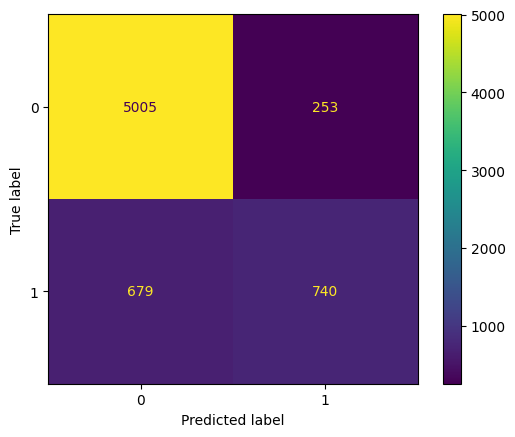

In [14]:
# Display Confusion Matrix
conf_matrix_plot(xgb_h1n1, X_test, y_test)

In [10]:
# Classification Report (H1N1)
print(classification_report(y_test, y_preds_test_h1n1))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5258
           1       0.75      0.52      0.61      1419

    accuracy                           0.86      6677
   macro avg       0.81      0.74      0.76      6677
weighted avg       0.85      0.86      0.85      6677



In [21]:
# Calculate ROC AUC score for XGB
roc_auc_train_xgb_h1n1 = roc_auc_score(y_train, y_pred_proba_train_h1n1[:,1])
roc_auc_test_xgb_h1n1 = roc_auc_score(y_test, y_pred_proba_test_h1n1[:,1])

# Print ROC AUC scores
print(f'AUROC XGB H1n1 Train: {roc_auc_train_xgb_h1n1}'
      f'\nAUROC XGB H1n1 Test: {roc_auc_test_xgb_h1n1}'
)

AUROC XGB H1n1 Train: 0.9020944726163495
AUROC XGB H1n1 Test: 0.8784268061205972


In [22]:
# Function to draw ROC curve and print score

def draw_roc_curve(test, pred_proba):
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(test, pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return roc_auc_score(test, pred_proba)

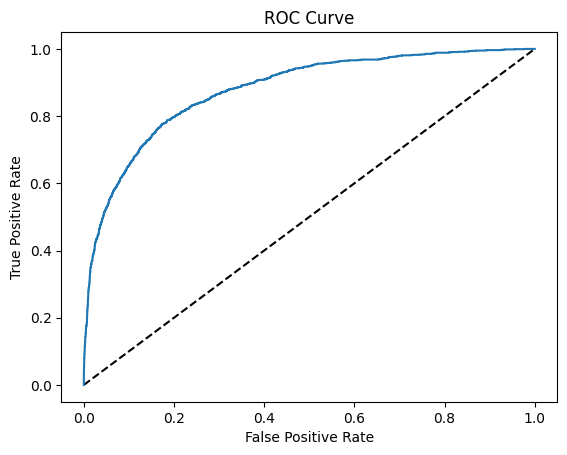

0.8784268061205972

In [23]:
# H1N1 Test
draw_roc_curve(y_test, y_pred_proba_test_h1n1[:,1])

### Looks good so far as hyperparameters are good for H1N1. Try Seasonal

## Create base model for seasonal (se) vax

In [15]:
# Split Data into Train/Test (75%/25%)
X_se = train_data_encoded.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y_se = train_data_encoded[['seasonal_vaccine']]

X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(X_se, y_se, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [16]:
# Create XGB Model for Seasonal
xgb_se = xgb.XGBClassifier(colsample_bytree=0.6, 
                           learning_rate=0.01,
                           max_depth=4,
                           n_estimators=1000,
                           subsample=0.3)

# Fit the model on the entire training set
xgb_se.fit(X_train_se, y_train_se)

# Predict probabilities for the TRAIN set
y_pred_proba_train_se = xgb_se.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se = xgb_se.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se = xgb_se.predict(X_test_se)

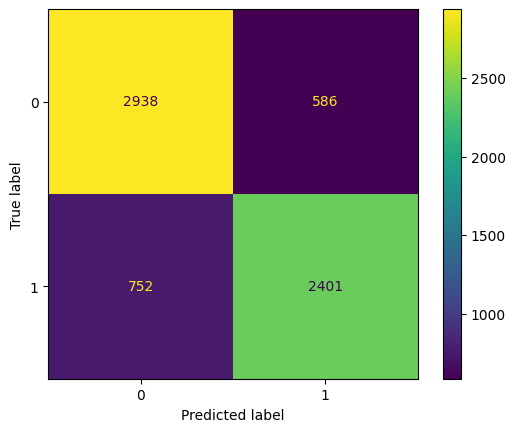

In [17]:
# Display Confusion Matrix
conf_matrix_plot(xgb_se, X_test_se, y_test_se)

In [48]:
# Classification Report (Seasonal)
print(classification_report(y_test_se, y_preds_test_se))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3524
           1       0.80      0.76      0.78      3153

    accuracy                           0.80      6677
   macro avg       0.80      0.80      0.80      6677
weighted avg       0.80      0.80      0.80      6677



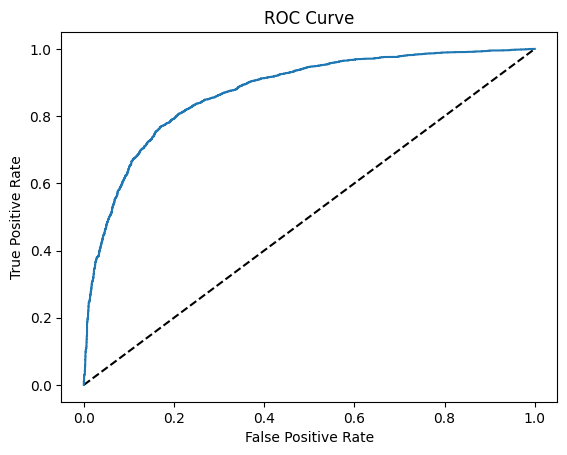

0.8727496073321519

In [24]:
# Seasonal Test
draw_roc_curve(y_test_se, y_pred_proba_test_se[:,1])

In [25]:
# Calculate ROC AUC score for XGB
roc_auc_train_xgb_se = roc_auc_score(y_train_se, y_pred_proba_train_se[:,1])
roc_auc_test_xgb_se = roc_auc_score(y_test_se, y_pred_proba_test_se[:,1])

# Print ROC AUC scores
print(f'AUROC XGB Seasonal Train: {roc_auc_train_xgb_se}'
      f'\nAUROC XGB Seasonal Test: {roc_auc_test_xgb_se}'
)

AUROC XGB Seasonal Train: 0.8768375160891415
AUROC XGB Seasonal Test: 0.8727496073321519


## Bayesian Optimization via Optuna

In [26]:
!pip install optuna

import optuna

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 38.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Optuna with H1N1

In [37]:
# From https://www.datasnips.com/293/optimizing-xgboost-hyperparameters-with-optuna/
# Step 1: Define the objective function for Optuna to minimize
def objective_h1n1(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1),
    }
    
    # Train an XGBoost model with the current hyperparameters
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_boost_round=1000, 
                      evals=[(dvalid, 'validation')], early_stopping_rounds=20, verbose_eval=False)
    
    # Evaluate the model on the validation set and return the score
    y_pred = model.predict(dvalid)
    return roc_auc_score(y_test, y_pred)

In [38]:
# Step 2: Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_h1n1, n_trials=100)

[I 2023-07-21 21:24:19,157] A new study created in memory with name: no-name-efa066bd-1665-45cf-991d-8e2ddb0c835e
[I 2023-07-21 21:24:20,744] Trial 0 finished with value: 0.8589802149870086 and parameters: {'max_depth': 4, 'learning_rate': 0.000342987582854932, 'subsample': 0.24059871518912776, 'colsample_bytree': 0.36690598130850927, 'min_child_weight': 0.0002755107299292709}. Best is trial 0 with value: 0.8589802149870086.
[I 2023-07-21 21:24:23,450] Trial 1 finished with value: 0.8756151571175412 and parameters: {'max_depth': 6, 'learning_rate': 0.04316387821896661, 'subsample': 0.6955910399797004, 'colsample_bytree': 0.8046167729395896, 'min_child_weight': 0.03203620530931276}. Best is trial 1 with value: 0.8756151571175412.
[I 2023-07-21 21:24:24,951] Trial 2 finished with value: 0.8553744473671583 and parameters: {'max_depth': 4, 'learning_rate': 0.0001108859831290457, 'subsample': 0.4348457556752271, 'colsample_bytree': 0.9259335274976217, 'min_child_weight': 0.1530919834470196}

In [39]:
# Step 3: Print the best hyperparameters and score found by Optuna
print(f'Best score: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.87816
Best parameters:
    max_depth: 5
    learning_rate: 0.0315181778773347
    subsample: 0.3202202580083733
    colsample_bytree: 0.8848537431680721
    min_child_weight: 0.18075727071480643


## Optuna with Seasonal

In [40]:
# Step 1: Define the objective function for Optuna to minimize
def objective_se(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1),
    }
    
    # Train an XGBoost model with the current hyperparameters
    dtrain = xgb.DMatrix(X_train_se, label=y_train_se)
    dvalid = xgb.DMatrix(X_test_se, label=y_test_se)
    model = xgb.train(params, dtrain, num_boost_round=1000, 
                      evals=[(dvalid, 'validation')], early_stopping_rounds=20, verbose_eval=False)
    
    # Evaluate the model on the validation set and return the score
    y_pred = model.predict(dvalid)
    return roc_auc_score(y_test_se, y_pred)

In [41]:
# Step 2: Create an Optuna study object and optimize the objective function
study_se = optuna.create_study(direction='maximize')
study_se.optimize(objective_se, n_trials=100)

[I 2023-07-21 21:38:10,767] A new study created in memory with name: no-name-dfa1eaf4-75cd-4071-98e2-5398138bb899
[I 2023-07-21 21:38:12,833] Trial 0 finished with value: 0.8588706483888467 and parameters: {'max_depth': 8, 'learning_rate': 0.0002741885095875314, 'subsample': 0.4711851638993163, 'colsample_bytree': 0.35094900657349337, 'min_child_weight': 0.0025076556685375367}. Best is trial 0 with value: 0.8588706483888467.
[I 2023-07-21 21:38:13,745] Trial 1 finished with value: 0.8411505104952025 and parameters: {'max_depth': 2, 'learning_rate': 0.01309393460714148, 'subsample': 0.307717012868085, 'colsample_bytree': 0.16083054123743362, 'min_child_weight': 0.4256307349168694}. Best is trial 0 with value: 0.8588706483888467.
[I 2023-07-21 21:38:15,657] Trial 2 finished with value: 0.8653115080929356 and parameters: {'max_depth': 9, 'learning_rate': 0.0019869331835188028, 'subsample': 0.8837269022254999, 'colsample_bytree': 0.4957813901980811, 'min_child_weight': 0.4464359520924987}.

In [42]:
# Step 3: Print the best hyperparameters and score found by Optuna
print(f'Best score: {study_se.best_value:.5f}')
print('Best parameters:')
for key, value in study_se.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.87484
Best parameters:
    max_depth: 5
    learning_rate: 0.03217156742354802
    subsample: 0.9882133490122514
    colsample_bytree: 0.2723823854292983
    min_child_weight: 0.0032118738505435636


## Fit Respective Models with Optuna Hyperparameters

In [50]:
# H1N1 w/ Optuna
xgb_h1n1_opt = xgb.XGBClassifier(max_depth=5,
                                 learning_rate=0.0315181778773347,
                                 subsample=0.3202202580083733,
                                 colsample_bytree=0.8848537431680721,
                                 min_child_weight=0.18075727071480643,
                                 n_estimators=1000)

# Fit the model on the entire training set
xgb_h1n1_opt.fit(X_train, y_train)

# Predict probabilities for the TRAIN set
y_pred_proba_train_h1n1_opt = xgb_h1n1_opt.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_h1n1_opt = xgb_h1n1_opt.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_h1n1_opt = xgb_h1n1_opt.predict(X_test)

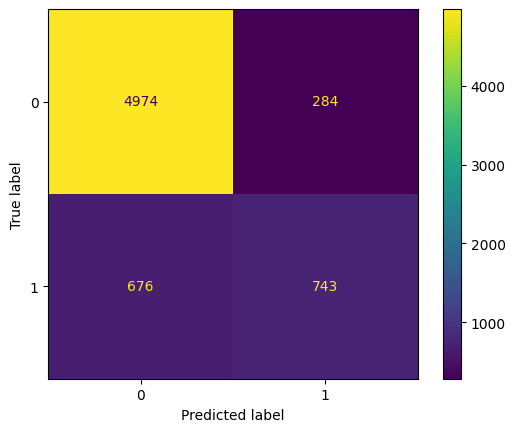

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5258
           1       0.72      0.52      0.61      1419

    accuracy                           0.86      6677
   macro avg       0.80      0.73      0.76      6677
weighted avg       0.85      0.86      0.85      6677



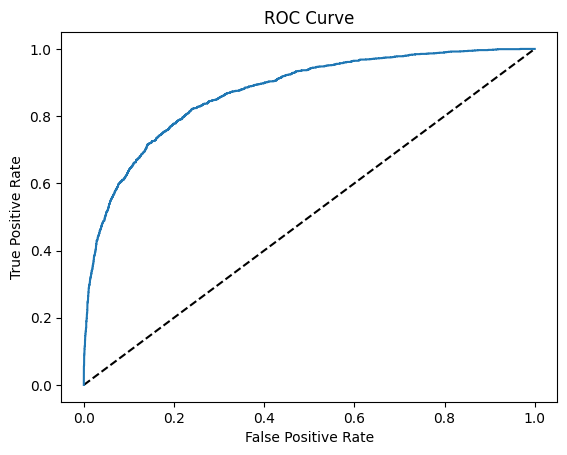

AUROC XGB H1N1 Train: 0.9490346958272265
AUROC XGB H1N1 Test: 0.8713713470208557


In [52]:
# Display Confusion Matrix
conf_matrix_plot(xgb_h1n1_opt, X_test, y_test)

# Classification Report (Seasonal)
print(classification_report(y_test, y_preds_test_h1n1_opt))

# Seasonal Test
draw_roc_curve(y_test, y_pred_proba_test_h1n1_opt[:,1])

# Calculate ROC AUC score for XGB
roc_auc_train_xgb_h1n1_opt = roc_auc_score(y_train, y_pred_proba_train_h1n1_opt[:,1])
roc_auc_test_xgb_h1n1_opt = roc_auc_score(y_test, y_pred_proba_test_h1n1_opt[:,1])

# Print ROC AUC scores
print(f'AUROC XGB H1N1 Train: {roc_auc_train_xgb_h1n1_opt}'
      f'\nAUROC XGB H1N1 Test: {roc_auc_test_xgb_h1n1_opt}'
)

In [56]:
# Seasonal w/ Optuna
xgb_se_opt = xgb.XGBClassifier(max_depth=5,
                               learning_rate=0.03217156742354802,
                               subsample=0.9882133490122514,
                               colsample_bytree=0.2723823854292983,
                               min_child_weight=0.0032118738505435636,
                               n_estimators=1000)

# Fit the model on the entire training set
xgb_se_opt.fit(X_train_se, y_train_se)

# Predict probabilities for the TRAIN set
y_pred_proba_train_se_opt = xgb_se_opt.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se_opt = xgb_se_opt.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se_opt = xgb_se_opt.predict(X_test_se)

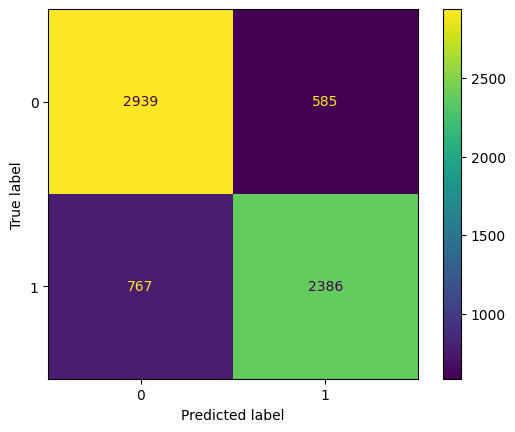

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3524
           1       0.80      0.76      0.78      3153

    accuracy                           0.80      6677
   macro avg       0.80      0.80      0.80      6677
weighted avg       0.80      0.80      0.80      6677



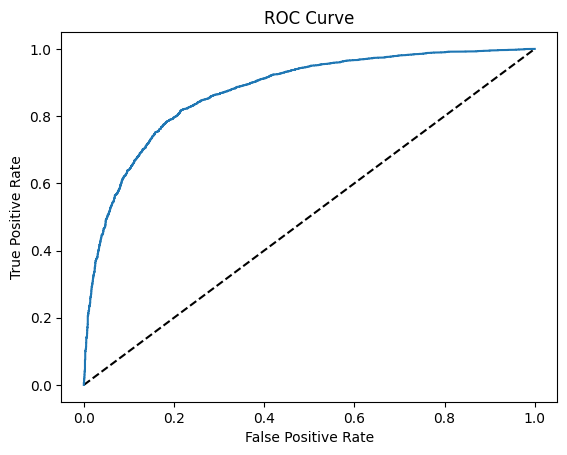

AUROC XGB Seasonal Train: 0.9174576718552068
AUROC XGB Seasonal Test: 0.87415314964074


In [57]:
# Display Confusion Matrix
conf_matrix_plot(xgb_se_opt, X_test_se, y_test_se)

# Classification Report (Seasonal)
print(classification_report(y_test_se, y_preds_test_se_opt))

# Seasonal Test
draw_roc_curve(y_test_se, y_pred_proba_test_se_opt[:,1])

# Calculate ROC AUC score for XGB
roc_auc_train_xgb_se_opt = roc_auc_score(y_train_se, y_pred_proba_train_se_opt[:,1])
roc_auc_test_xgb_se_opt = roc_auc_score(y_test_se, y_pred_proba_test_se_opt[:,1])

# Print ROC AUC scores
print(f'AUROC XGB Seasonal Train: {roc_auc_train_xgb_se_opt}'
      f'\nAUROC XGB Seasonal Test: {roc_auc_test_xgb_se_opt}'
)

## Predict on Unseen Data

In [58]:
# Join test_set_feat and train_set_lab by 'respondent_id' column
test_data = test_set_feat

test_data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [59]:
# Use function to transform test set data
test_data_encoded = data_encoding(test_data)

In [60]:
%%time

# Fit on Entire Training Dataset (H1N1)
xgb_h1n1_opt.fit(X, y)

# Fit on Entire Training Dataset (Seasonal)
xgb_se_opt.fit(X_se, y_se)

CPU times: user 3min 2s, sys: 453 ms, total: 3min 3s
Wall time: 23 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.2723823854292983, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03217156742354802,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=0.0032118738505435636, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [62]:
# Predict probabilities for the unseen data (H1N1)
y_test_data_pred_proba_xgb_h1n1 = xgb_h1n1_opt.predict_proba(test_data_encoded)
print(y_test_data_pred_proba_xgb_h1n1[:,1])

# Predict probabilities for the unseen data (Seasonal)
y_test_data_pred_proba_xgb_se = xgb_se_opt.predict_proba(test_data_encoded)
print(y_test_data_pred_proba_xgb_se[:,1])


[0.0480988  0.04258372 0.18489295 ... 0.1334713  0.01091306 0.5827877 ]
[0.22303073 0.0218151  0.701473   ... 0.15736638 0.29698724 0.5312235 ]


## Export to CSV

In [63]:
# Insert columns into 'submission'
submission['h1n1_vaccine'] = y_test_data_pred_proba_xgb_h1n1[:,1]
submission['seasonal_vaccine'] = y_test_data_pred_proba_xgb_se[:,1]

submission.to_csv('Submission_Files/submission(CAIRO-XGB4).csv', index=False)

In [64]:
submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.048099,0.223031
1,26708,0.042584,0.021815
2,26709,0.184893,0.701473
3,26710,0.748476,0.903596
4,26711,0.330913,0.397775
...,...,...,...
26703,53410,0.268905,0.444551
26704,53411,0.135569,0.362573
26705,53412,0.133471,0.157366
26706,53413,0.010913,0.296987
